# Notebook 03: DFT Setup Fundamentals

## Making the Right Choices Before Calculations

This notebook covers the critical decisions you must make before running DFT calculations:
- Exchange-correlation functional
- Pseudopotential selection
- Cutoff energies
- K-point sampling

---

## 1. Exchange-Correlation Functionals

### The Hierarchy

| Functional | Accuracy | Cost | When to Use |
|------------|----------|------|-------------|
| **LDA** | Low | Low | Qualitative trends, metals |
| **GGA (PBE)** | Medium | Low | Standard for most calculations |
| **GGA+U** | Medium-High | Low | Strongly correlated (d/f electrons) |
| **meta-GGA (SCAN)** | High | Medium | Better energetics |
| **Hybrid (HSE)** | High | High | Accurate band gaps |

### Typical Errors

| Property | LDA | GGA (PBE) |
|----------|-----|----------|
| Lattice parameter | -1 to -3% | +1 to +3% |
| Band gap | Underestimate | Underestimate |
| Formation energy | Overbinding | Better |

In [1]:
# =============================================================================
# SETUP - Run this cell first
# =============================================================================

import sys
from pathlib import Path

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

from pymatgen.core import Structure, Lattice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

import spglib

from ase import Atoms
from ase.build import bulk
from ase.io import read, write

print_workshop_banner()

print("\nSSP Cutoff Recommendations (from SSSP v1.3 Efficiency):")
print("=" * 60)
print(f"{'Element':<10} {'ecutwfc (Ry)':<15} {'ecutrho factor':<15}")
print("-" * 40)
for elem in ['Si', 'Al', 'Fe', 'O', 'Ti', 'Sr', 'Cu', 'N']:
    if elem in SSSP_EFFICIENCY:
        ecut, dual, _ = SSSP_EFFICIENCY[elem]
        print(f"{elem:<10} {ecut:<15} {dual}x")
print("=" * 60)

/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


QUANTUM ESPRESSO WORKSHOP - SETUP

Paths:
  Workshop root:     /home/niel/git/DFT_Tutorial/qe_workshop_complete
  Pseudopotentials:  /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials
  Output directory:  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs

QE Executables:
  pw.x:    /home/niel/src/qe-7.5/bin/pw.x
  MPI:     /usr/bin/mpirun
  NPROCS:  4

Available functionals: PBE, LDA, PBEsol
Elements in database: PBE(70), LDA(34), PBEsol(38)

SSP Cutoff Recommendations (from SSSP v1.3 Efficiency):
Element    ecutwfc (Ry)    ecutrho factor 
----------------------------------------
Si         40              8x
Al         30              8x
Fe         90              12x
O          75              8x
Ti         60              8x
Sr         40              8x
Cu         55              8x
N          80              8x


---

## Visualizing the Electron Density - The Heart of DFT!

**This is DENSITY Functional Theory** - the electron density $n(\mathbf{r})$ is the central quantity!

Unlike molecules where we visualize HOMO/LUMO orbitals, in solids we visualize:
- **Total charge density** $n(\mathbf{r})$ - Shows bonding character
- **Charge density difference** $\Delta n = n_{solid} - n_{atoms}$ - Shows charge redistribution
- **Partial charge density** - Charge from specific bands/energy ranges

### Visualization Workflow

```
SCF calculation → pp.x (post-processing) → .cube file → VESTA/XCrySDen
```

### What You'll See
- **Covalent bonds**: Charge accumulation between atoms (Si, C)
- **Ionic bonds**: Charge on anions, depleted on cations (NaCl)
- **Metallic bonds**: Uniform "sea" of electrons (Al, Cu)

In [2]:
# =============================================================================
# CHARGE DENSITY VISUALIZATION - The Heart of DFT!
# =============================================================================
# After ANY SCF calculation, you can visualize the electron density.
# This generates .cube files viewable in VESTA, XCrySDen, or py3Dmol.
# =============================================================================

def generate_pp_input_charge(prefix: str, outdir: str = './tmp',
                             output_file: str = 'charge.cube',
                             plot_type: str = 'charge') -> str:
    """
    Generate pp.x input for charge density visualization.
    
    Parameters
    ----------
    prefix : str
        Must match SCF calculation prefix
    plot_type : str
        'charge' - Total charge density
        'spin'   - Spin polarization (nspin=2 only)
        'potential' - Local potential
    
    Returns
    -------
    str : pp.x input file content
    """
    plot_num = {'charge': 0, 'spin': 6, 'potential': 1, 'elf': 8}
    
    return f"""&INPUTPP
    prefix = '{prefix}'
    outdir = '{outdir}'
    filplot = '{prefix}.pp'
    plot_num = {plot_num.get(plot_type, 0)}
/

&PLOT
    nfile = 1
    filepp(1) = '{prefix}.pp'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = '{output_file}'
/
"""


def generate_pp_input_partial_charge(prefix: str, outdir: str = './tmp',
                                     emin: float = -5.0, emax: float = 0.0,
                                     output_file: str = 'partial_charge.cube') -> str:
    """
    Generate pp.x input for partial charge density (specific energy range).
    
    Useful for visualizing:
    - Valence band states (emax = Fermi level)
    - Conduction band states (emin = Fermi level)
    - States near band edges
    """
    return f"""&INPUTPP
    prefix = '{prefix}'
    outdir = '{outdir}'
    filplot = '{prefix}_partial.pp'
    plot_num = 7
    emin = {emin}
    emax = {emax}
/

&PLOT
    nfile = 1
    filepp(1) = '{prefix}_partial.pp'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = '{output_file}'
/
"""


def run_charge_density_visualization(prefix: str, work_dir, nprocs: int = 1):
    """
    Run pp.x to generate charge density cube file after SCF.
    
    Returns path to .cube file for VESTA visualization.
    """
    pp_file = work_dir / f'{prefix}_pp.in'
    cube_file = work_dir / f'{prefix}_charge.cube'
    
    pp_input = generate_pp_input_charge(prefix, output_file=str(cube_file))
    
    with open(pp_file, 'w') as f:
        f.write(pp_input)
    
    print(f"Running pp.x to generate charge density...")
    output, elapsed, _ = run_qe(pp_file, executable='pp.x', nprocs=nprocs)
    
    if cube_file.exists():
        print(f"✓ Charge density saved to: {cube_file}")
        print(f"\nTo visualize:")
        print(f"  1. Open VESTA")
        print(f"  2. File → Open → Select {cube_file.name}")
        print(f"  3. Use 'Isosurfaces' to see 3D density")
        return cube_file
    else:
        print("⚠ Cube file not generated - check pp.x output")
        return None


# Example pp.x inputs
print("=" * 70)
print("CHARGE DENSITY VISUALIZATION - pp.x Input Examples")
print("=" * 70)

print("\n1. Total Charge Density (after SCF):")
print("-" * 50)
print(generate_pp_input_charge('silicon'))

print("\n2. Partial Charge (valence states near Fermi level):")
print("-" * 50)
print(generate_pp_input_partial_charge('silicon', emin=-5.0, emax=0.0))

print("\n" + "=" * 70)
print("VIEWING IN VESTA:")
print("=" * 70)
print("""
1. Open VESTA and load the .cube file
2. Go to Properties → Isosurfaces
3. Set isosurface level (try 0.01-0.05 e/Å³ for charge)
4. Use 'Boundary' to extend visualization across unit cells
5. For bonding analysis: compare total vs. atomic superposition
""")

CHARGE DENSITY VISUALIZATION - pp.x Input Examples

1. Total Charge Density (after SCF):
--------------------------------------------------
&INPUTPP
    prefix = 'silicon'
    outdir = './tmp'
    filplot = 'silicon.pp'
    plot_num = 0
/

&PLOT
    nfile = 1
    filepp(1) = 'silicon.pp'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = 'charge.cube'
/


2. Partial Charge (valence states near Fermi level):
--------------------------------------------------
&INPUTPP
    prefix = 'silicon'
    outdir = './tmp'
    filplot = 'silicon_partial.pp'
    plot_num = 7
    emin = -5.0
    emax = 0.0
/

&PLOT
    nfile = 1
    filepp(1) = 'silicon_partial.pp'
    weight(1) = 1.0
    iflag = 3
    output_format = 6
    fileout = 'partial_charge.cube'
/


VIEWING IN VESTA:

1. Open VESTA and load the .cube file
2. Go to Properties → Isosurfaces
3. Set isosurface level (try 0.01-0.05 e/Å³ for charge)
4. Use 'Boundary' to extend visualization across unit cells
5. For bonding analy

---

## 2. Pseudopotential Selection

### Types of Pseudopotentials

| Type | ecutrho | Accuracy | Speed | Use Case |
|------|---------|----------|-------|----------|
| **NC** (Norm-conserving) | 4× ecutwfc | Good | Fast | Quick tests, light elements |
| **US** (Ultrasoft) | 8-12× ecutwfc | Good | Medium | General purpose |
| **PAW** (Projector Augmented Wave) | 8× ecutwfc | Best | Slower | Production, all-electron precision |

### Recommended Libraries

1. **SSSP** (Standard Solid-State Pseudopotentials) - Materials Cloud
   - Efficiency set: Fast calculations
   - Precision set: High accuracy
   - URL: https://www.materialscloud.org/discover/sssp

2. **PSlibrary** - QE standard library
   - URL: https://dalcorso.github.io/pslibrary/

In [3]:
# Pseudopotential information
SSSP_RECOMMENDATIONS = {
    # Element: (ecutwfc, dual, PP_file)
    'H':  (60, 8, 'H.pbe-rrkjus_psl.1.0.0.UPF'),
    'C':  (50, 8, 'C.pbe-n-kjpaw_psl.1.0.0.UPF'),
    'N':  (80, 8, 'N.pbe-n-kjpaw_psl.1.0.0.UPF'),
    'O':  (75, 8, 'O.pbe-n-kjpaw_psl.1.0.0.UPF'),
    'Si': (40, 8, 'Si.pbe-n-kjpaw_psl.1.0.0.UPF'),
    'Fe': (90, 12, 'Fe.pbe-spn-kjpaw_psl.1.0.0.UPF'),
    'Ti': (60, 8, 'Ti.pbe-spn-kjpaw_psl.1.0.0.UPF'),
    'Sr': (40, 8, 'Sr.pbe-spn-kjpaw_psl.1.0.0.UPF'),
    'Ba': (35, 8, 'Ba.pbe-spn-kjpaw_psl.1.0.0.UPF'),
}


def get_recommended_cutoffs_demo(elements):
    """
    Get recommended cutoffs for a set of elements.
    Returns the maximum ecutwfc and appropriate ecutrho.
    """
    max_ecutwfc = 0
    max_dual = 4

    for elem in elements:
        if elem in SSSP_RECOMMENDATIONS:
            ecutwfc, dual, _ = SSSP_RECOMMENDATIONS[elem]
            max_ecutwfc = max(max_ecutwfc, ecutwfc)
            max_dual = max(max_dual, dual)
        else:
            print(f"Warning: {elem} not in database, using defaults")
            max_ecutwfc = max(max_ecutwfc, 60)

    return max_ecutwfc, max_ecutwfc * max_dual


# Example
elements = ['Sr', 'Ti', 'O']
ecutwfc, ecutrho = get_recommended_cutoffs_demo(elements)
print(f"\nRecommended cutoffs for SrTiO3:")
print(f"  ecutwfc = {ecutwfc} Ry")
print(f"  ecutrho = {ecutrho} Ry")
print(f"\nNote: ALWAYS verify with convergence tests!")


Recommended cutoffs for SrTiO3:
  ecutwfc = 75 Ry
  ecutrho = 600 Ry

Note: ALWAYS verify with convergence tests!


---

## 3. K-point Sampling

### Rules of Thumb

- **Metals**: Dense grids needed (12×12×12 or more)
- **Semiconductors**: Moderate (6×6×6 to 8×8×8)
- **Insulators**: Coarser grids sufficient (4×4×4 to 6×6×6)
- **Large cells**: Fewer k-points needed (k × L ≈ constant)

### K-point Density

A useful metric is k-points per reciprocal atom (KPRA):
- ~1000 KPRA for insulators
- ~3000 KPRA for semiconductors
- ~5000+ KPRA for metals

In [4]:
def estimate_kpoints(lattice_params, n_atoms, material_type='semiconductor'):
    """
    Estimate k-point grid based on lattice parameters and material type.
    
    Parameters
    ----------
    lattice_params : tuple
        (a, b, c) in Angstrom
    n_atoms : int
        Number of atoms in unit cell
    material_type : str
        'metal', 'semiconductor', or 'insulator'
    
    Returns
    -------
    tuple : (kx, ky, kz)
    """
    a, b, c = lattice_params
    
    # Target k-point density (reciprocal Å⁻¹)
    densities = {
        'metal': 0.03,
        'semiconductor': 0.05,
        'insulator': 0.07
    }
    target_spacing = densities.get(material_type, 0.05)
    
    # k_i ≈ 1 / (a_i × spacing)
    kx = max(1, int(np.ceil(1 / (a * target_spacing))))
    ky = max(1, int(np.ceil(1 / (b * target_spacing))))
    kz = max(1, int(np.ceil(1 / (c * target_spacing))))
    
    # Make odd for better symmetry
    kx = kx if kx % 2 == 1 else kx + 1
    ky = ky if ky % 2 == 1 else ky + 1
    kz = kz if kz % 2 == 1 else kz + 1
    
    return (kx, ky, kz)

# Examples
print("K-point Grid Estimation")
print("=" * 50)

materials = [
    ('Si (5.43 Å)', (5.43, 5.43, 5.43), 2, 'semiconductor'),
    ('Fe (2.87 Å)', (2.87, 2.87, 2.87), 2, 'metal'),
    ('MgO (4.21 Å)', (4.21, 4.21, 4.21), 2, 'insulator'),
]

for name, params, natoms, mtype in materials:
    kpts = estimate_kpoints(params, natoms, mtype)
    print(f"\n{name} ({mtype}):")
    print(f"  Suggested grid: {kpts[0]}×{kpts[1]}×{kpts[2]}")

K-point Grid Estimation

Si (5.43 Å) (semiconductor):
  Suggested grid: 5×5×5

Fe (2.87 Å) (metal):
  Suggested grid: 13×13×13

MgO (4.21 Å) (insulator):
  Suggested grid: 5×5×5


---

## 4. Complete Input File Generator

In [5]:
def generate_scf_input(prefix, ecutwfc, ecutrho, kpoints, pseudo_dir,
                       celldm1=None, cell_parameters=None,
                       atomic_species=None, atomic_positions=None,
                       nspin=1, starting_magnetization=None,
                       hubbard_u=None, conv_thr=1.0e-8):
    """
    Generate a complete SCF input file for Quantum ESPRESSO.
    
    This function creates properly formatted input files following
    best practices for DFT calculations.
    """
    lines = []
    
    # CONTROL namelist
    lines.append("&CONTROL")
    lines.append("    calculation = 'scf'")
    lines.append(f"    prefix = '{prefix}'")
    lines.append("    outdir = './tmp'")
    lines.append(f"    pseudo_dir = '{pseudo_dir}'")
    lines.append("    verbosity = 'high'")
    lines.append("    tprnfor = .true.")
    lines.append("    tstress = .true.")
    lines.append("/")
    lines.append("")
    
    # SYSTEM namelist
    lines.append("&SYSTEM")
    
    if celldm1 is not None:
        lines.append("    ibrav = 0")  # Use CELL_PARAMETERS
        lines.append(f"    celldm(1) = {celldm1}")
    else:
        lines.append("    ibrav = 0")
    
    if atomic_species:
        nat = sum(len([p for p in atomic_positions if p[0] == s[0]]) 
                  for s in atomic_species) if atomic_positions else 2
        ntyp = len(atomic_species)
    else:
        nat = 2
        ntyp = 1
    
    lines.append(f"    nat = {nat}")
    lines.append(f"    ntyp = {ntyp}")
    lines.append(f"    ecutwfc = {ecutwfc}")
    lines.append(f"    ecutrho = {ecutrho}")
    lines.append("    occupations = 'smearing'")
    lines.append("    smearing = 'cold'")
    lines.append("    degauss = 0.01")
    
    if nspin == 2:
        lines.append(f"    nspin = {nspin}")
        if starting_magnetization:
            for i, mag in enumerate(starting_magnetization, 1):
                lines.append(f"    starting_magnetization({i}) = {mag}")
    
    if hubbard_u:
        lines.append("    lda_plus_u = .true.")
        for i, u in enumerate(hubbard_u, 1):
            lines.append(f"    Hubbard_U({i}) = {u}")
    
    lines.append("/")
    lines.append("")
    
    # ELECTRONS namelist
    lines.append("&ELECTRONS")
    lines.append(f"    conv_thr = {conv_thr}")
    lines.append("    mixing_beta = 0.7")
    lines.append("/")
    lines.append("")
    
    # ATOMIC_SPECIES
    lines.append("ATOMIC_SPECIES")
    if atomic_species:
        for symbol, mass, pp_file in atomic_species:
            lines.append(f"    {symbol}  {mass}  {pp_file}")
    else:
        lines.append("    Si  28.0855  Si.upf")
    lines.append("")
    
    # CELL_PARAMETERS
    if cell_parameters is not None:
        lines.append("CELL_PARAMETERS {angstrom}")
        for vec in cell_parameters:
            lines.append(f"    {vec[0]:12.8f}  {vec[1]:12.8f}  {vec[2]:12.8f}")
        lines.append("")
    
    # ATOMIC_POSITIONS
    lines.append("ATOMIC_POSITIONS {crystal}")
    if atomic_positions:
        for symbol, x, y, z in atomic_positions:
            lines.append(f"    {symbol}  {x:12.8f}  {y:12.8f}  {z:12.8f}")
    else:
        lines.append("    Si  0.00  0.00  0.00")
        lines.append("    Si  0.25  0.25  0.25")
    lines.append("")
    
    # K_POINTS
    kx, ky, kz = kpoints if isinstance(kpoints, tuple) else (kpoints, kpoints, kpoints)
    lines.append("K_POINTS {automatic}")
    lines.append(f"    {kx} {ky} {kz} 0 0 0")
    
    return '\n'.join(lines)

# Example: Generate input for SrTiO3
print("Example: SrTiO3 SCF Input")
print("=" * 60)

srtio3_input = generate_scf_input(
    prefix='srtio3',
    ecutwfc=75,
    ecutrho=600,
    kpoints=(6, 6, 6),
    pseudo_dir='./pseudopotentials',
    cell_parameters=[
        [3.905, 0.0, 0.0],
        [0.0, 3.905, 0.0],
        [0.0, 0.0, 3.905]
    ],
    atomic_species=[
        ('Sr', 87.62, 'Sr.pbe-spn-kjpaw_psl.1.0.0.UPF'),
        ('Ti', 47.867, 'Ti.pbe-spn-kjpaw_psl.1.0.0.UPF'),
        ('O', 15.999, 'O.pbe-n-kjpaw_psl.1.0.0.UPF')
    ],
    atomic_positions=[
        ('Sr', 0.0, 0.0, 0.0),
        ('Ti', 0.5, 0.5, 0.5),
        ('O', 0.5, 0.5, 0.0),
        ('O', 0.5, 0.0, 0.5),
        ('O', 0.0, 0.5, 0.5)
    ]
)

print(srtio3_input)

Example: SrTiO3 SCF Input
&CONTROL
    calculation = 'scf'
    prefix = 'srtio3'
    outdir = './tmp'
    pseudo_dir = './pseudopotentials'
    verbosity = 'high'
    tprnfor = .true.
    tstress = .true.
/

&SYSTEM
    ibrav = 0
    nat = 5
    ntyp = 3
    ecutwfc = 75
    ecutrho = 600
    occupations = 'smearing'
    smearing = 'cold'
    degauss = 0.01
/

&ELECTRONS
    conv_thr = 1e-08
    mixing_beta = 0.7
/

ATOMIC_SPECIES
    Sr  87.62  Sr.pbe-spn-kjpaw_psl.1.0.0.UPF
    Ti  47.867  Ti.pbe-spn-kjpaw_psl.1.0.0.UPF
    O  15.999  O.pbe-n-kjpaw_psl.1.0.0.UPF

CELL_PARAMETERS {angstrom}
      3.90500000    0.00000000    0.00000000
      0.00000000    3.90500000    0.00000000
      0.00000000    0.00000000    3.90500000

ATOMIC_POSITIONS {crystal}
    Sr    0.00000000    0.00000000    0.00000000
    Ti    0.50000000    0.50000000    0.50000000
    O    0.50000000    0.50000000    0.00000000
    O    0.50000000    0.00000000    0.50000000
    O    0.00000000    0.50000000    0.50000

---

## 5. Common Mistakes to Avoid

| Mistake | Consequence | Solution |
|---------|-------------|----------|
| Wrong PP type | Incorrect ecutrho | Check PP documentation |
| Insufficient ecutwfc | Unconverged energies | Run convergence test |
| Too few k-points | Wrong energetics | Increase grid for metals |
| Missing +U for d/f | Wrong electronic structure | Add Hubbard U |
| Smearing for insulators | Artificial metallicity | Use 'tetrahedra' or small degauss |

---

## 6. HANDS-ON: Run a REAL Calculation with Germanium

Now let's put everything together and run an actual SCF calculation!

In [6]:
# =============================================================================
# HANDS-ON: Run a REAL SCF Calculation for Germanium
# =============================================================================
# This demonstrates everything we learned: pseudopotentials, cutoffs, k-points
# =============================================================================

from datetime import datetime
from ase.build import bulk
from ase.io.espresso import write_espresso_in

# Material setup - Germanium (diamond structure)
MATERIAL = 'Ge'
LATTICE_A = 5.66  # Angstrom (experimental)

atoms = bulk(MATERIAL, 'diamond', a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

print(f"{'='*70}")
print(f"REAL CALCULATION: {MATERIAL} (Diamond Structure)")
print(f"{'='*70}")
print(f"Lattice parameter: {LATTICE_A} Å")
print(f"Number of atoms: {len(atoms)}")
print(f"Volume: {atoms.get_volume():.3f} Å³")

# Setup pseudopotentials (automatic download)
pp_files = setup_pseudopotentials(elements, 'PBE')

# Get SSSP recommended cutoffs
ecutwfc, ecutrho = get_recommended_cutoffs(elements, 'PBE')
print(f"\nSSP Recommended cutoffs for {MATERIAL}:")
print(f"  ecutwfc = {ecutwfc} Ry")
print(f"  ecutrho = {ecutrho} Ry")

# Estimate k-points
kpts = estimate_kpoints((LATTICE_A, LATTICE_A, LATTICE_A), len(atoms), 'semiconductor')
print(f"  K-points: {kpts[0]}×{kpts[1]}×{kpts[2]}")

# Create working directory
work_dir = OUTPUT_DIR / f'03_Ge_scf_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
work_dir.mkdir(parents=True, exist_ok=True)

# Generate QE input file
prefix = 'ge_scf'
input_file = work_dir / f'{prefix}.in'

pseudopotentials = {elem: get_pseudopotential_filename(elem, 'PBE') for elem in elements}
input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir('PBE')),
        'verbosity': 'high',
        'tprnfor': True,
        'tstress': True,
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {
        'conv_thr': 1.0e-8,
    },
}

write_espresso_in(input_file, atoms, input_data=input_data,
                  pseudopotentials=pseudopotentials, kpts=(8, 8, 8))

print(f"\nInput file created: {input_file}")
print(f"\n{'='*70}")
print("INPUT FILE CONTENT:")
print(f"{'='*70}")
print(input_file.read_text()[:1500])
print("...")

REAL CALCULATION: Ge (Diamond Structure)
Lattice parameter: 5.66 Å
Number of atoms: 2
Volume: 45.330 Å³
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Ge: Ge.pbe-dn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

SSP Recommended cutoffs for Ge:
  ecutwfc = 45 Ry
  ecutrho = 360 Ry
  K-points: 5×5×5

Input file created: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/03_Ge_scf_20260204_192110/ge_scf.in

INPUT FILE CONTENT:
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = './tmp'
   prefix           = 'ge_scf'
   pseudo_dir       = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
/
&SYSTEM
   ecutwfc          = 45
   ecutrho          = 360
   occupations      = 'smearing'
   degauss          = 0.01
   smearing         = 'cold'
   ntyp             = 1
   nat              = 2
   ibrav            = 0
/
&ELECTR

In [7]:
# =============================================================================
# RUN THE CALCULATION AND ANALYZE RESULTS
# =============================================================================

print(f"Running SCF calculation for {MATERIAL}...")
print(f"Using {NPROCS} MPI processes")
print("This may take 1-2 minutes...\n")

output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)

# Save output
output_file = work_dir / f'{prefix}.out'
output_file.write_text(output)

# Parse results
results = parse_qe_output(output)

print(f"\n{'='*70}")
print(f"SCF CALCULATION RESULTS: {MATERIAL}")
print(f"{'='*70}")
print(f"Converged: {'✓ YES' if converged else '✗ NO'}")
print(f"Wall time: {elapsed:.1f} seconds")

if results['total_energy_ev']:
    print(f"\n--- ENERGETICS ---")
    print(f"Total energy: {results['total_energy_ev']:.6f} eV")
    print(f"Energy per atom: {results['total_energy_ev']/len(atoms):.6f} eV/atom")
    print(f"Total energy: {results['total_energy_ev']/RY_TO_EV:.8f} Ry")

if results['pressure_kbar']:
    print(f"\n--- STRESS ---")
    print(f"Pressure: {results['pressure_kbar']:.2f} kbar")
    if abs(results['pressure_kbar']) < 5:
        print("  → Cell is well equilibrated (P ≈ 0)")
    elif results['pressure_kbar'] > 0:
        print("  → Positive pressure: cell may be slightly compressed")
    else:
        print("  → Negative pressure: cell may be slightly expanded")

if results['fermi_energy_ev']:
    print(f"\n--- ELECTRONIC STRUCTURE ---")
    print(f"Fermi energy: {results['fermi_energy_ev']:.4f} eV")

if results['n_scf_iterations']:
    print(f"\n--- CONVERGENCE ---")
    print(f"SCF iterations: {results['n_scf_iterations']}")

print(f"\n{'='*70}")
print(f"Output saved to: {output_file}")
print(f"{'='*70}")

Running SCF calculation for Ge...
Using 4 MPI processes
This may take 1-2 minutes...

Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in ge_scf.in


  ✓ Converged in 77.6s

SCF CALCULATION RESULTS: Ge
Converged: ✓ YES
Wall time: 77.6 seconds

--- ENERGETICS ---
Total energy: -8586.211057 eV
Energy per atom: -4293.105529 eV/atom
Total energy: -631.07487282 Ry

--- STRESS ---
Pressure: 30.16 kbar
  → Positive pressure: cell may be slightly compressed

--- ELECTRONIC STRUCTURE ---
Fermi energy: 8.5282 eV

--- CONVERGENCE ---
SCF iterations: 7

Output saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/03_Ge_scf_20260204_192110/ge_scf.out


/tmp/ipykernel_2133302/1224341210.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


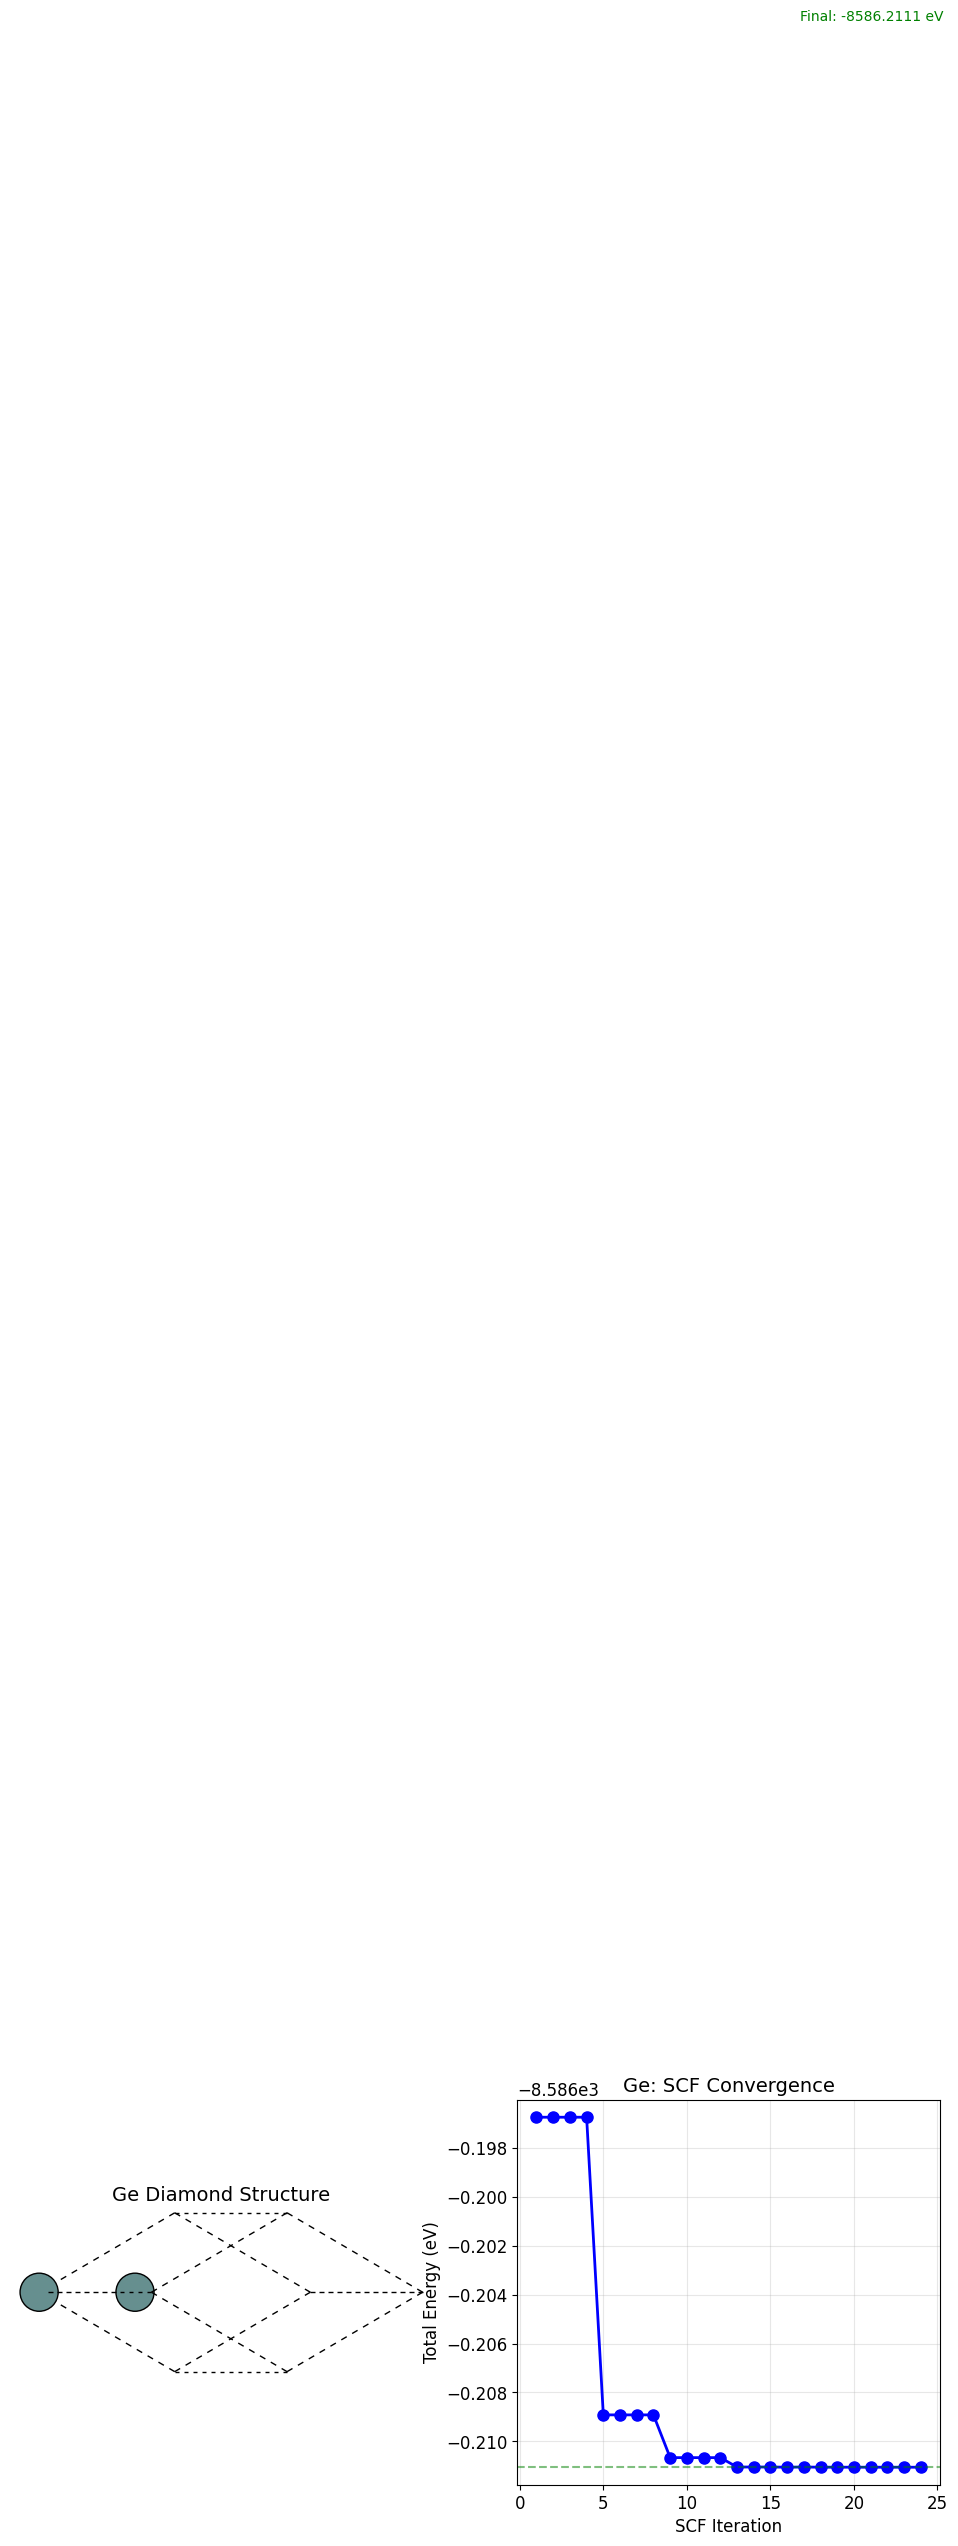


Figure saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/03_Ge_scf_20260204_192110/Ge_scf_results.png


In [8]:
# =============================================================================
# VISUALIZE THE STRUCTURE AND RESULTS
# =============================================================================

import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Structure visualization
ax1 = axes[0]
plot_atoms(atoms, ax1, radii=0.4, rotation='45x,45y,0z')
ax1.set_title(f'{MATERIAL} Diamond Structure', fontsize=14)
ax1.axis('off')

# Plot 2: Energy convergence from SCF iterations (parse from output)
ax2 = axes[1]
import re
scf_energies = []
for line in output.split('\n'):
    if 'total energy' in line and '!' not in line and 'estimated' not in line.lower():
        match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
        if match:
            scf_energies.append(float(match.group(1)) * RY_TO_EV)

if scf_energies:
    iterations = range(1, len(scf_energies) + 1)
    ax2.plot(iterations, scf_energies, 'bo-', markersize=8, linewidth=2)
    ax2.set_xlabel('SCF Iteration', fontsize=12)
    ax2.set_ylabel('Total Energy (eV)', fontsize=12)
    ax2.set_title(f'{MATERIAL}: SCF Convergence', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Add final energy annotation
    ax2.axhline(y=scf_energies[-1], color='g', linestyle='--', alpha=0.5)
    ax2.annotate(f'Final: {scf_energies[-1]:.4f} eV', 
                xy=(len(scf_energies), scf_energies[-1]),
                xytext=(len(scf_energies)*0.7, scf_energies[-1] + 0.1),
                fontsize=10, color='green')

plt.tight_layout()

# Save figure
fig_path = work_dir / f'{MATERIAL}_scf_results.png'
fig.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved: {fig_path}")

---

## Summary

Before running calculations, verify:

1. ✓ **Functional**: PBE for most, +U for d/f metals, HSE for gaps
2. ✓ **Pseudopotentials**: SSSP library, correct type (NC/US/PAW)
3. ✓ **Cutoffs**: Use PP recommendations, verify with convergence
4. ✓ **K-points**: Dense for metals, moderate for semiconductors

### Next Notebook
→ **04_Convergence_Testing.ipynb**: Systematic convergence tests